In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
# Загрузка и агрегация данных по дням (среднее значение за день)
df = pd.read_csv('filtered_dataset.csv', parse_dates=['date'])
df_daily = df.groupby(df['date'].dt.date).agg({'value': 'mean'}).reset_index()
df_daily['date'] = pd.to_datetime(df_daily['date'])

# Масштабирование значений
scaler = MinMaxScaler()
values = scaler.fit_transform(df_daily['value'].values.reshape(-1, 1))


In [2]:
def create_sequences(data, window_size=14, forecast_horizon=2):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+forecast_horizon].flatten())
    return np.array(X), np.array(y)

window_size = 7  # Размер окна (дней)
forecast_horizon = 31  # На сколько дней вперёд прогноз
X, y = create_sequences(values, window_size, forecast_horizon)

# Разделение на обучающую и тестовую выборки
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]



In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dense(forecast_horizon)
])

model.compile(optimizer='adam', loss='mse')


2025-07-14 15:13:29.631286: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-14 15:13:29.771702: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-14 15:13:29.799871: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-14 15:13:30.337118: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [4]:
# Преобразование формы для Conv1D/LSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

history = model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test)
)


Epoch 1/100


2025-07-14 15:13:33.802347: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-07-14 15:13:34.736900: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-07-14 15:13:34.738940: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-07-14 15:13:34.739061: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2025-07-14 15:13:34.740720: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-07-14 15:13:34.740863: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-07-14 15:13:35.544876: I tensorflow/stream_executor/cuda/c

9/9 [==============================] - 4s 45ms/step - loss: 0.1594 - val_loss: 0.4484
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 0.1432 - val_loss: 0.4068
Epoch 3/100
9/9 [==============================] - 0s 6ms/step - loss: 0.1233 - val_loss: 0.3475
Epoch 4/100
9/9 [==============================] - 0s 7ms/step - loss: 0.0950 - val_loss: 0.2602
Epoch 5/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0598 - val_loss: 0.1476
Epoch 6/100
9/9 [==============================] - 0s 7ms/step - loss: 0.0319 - val_loss: 0.0597
Epoch 7/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0227 - val_loss: 0.0322
Epoch 8/100
9/9 [==============================] - 0s 7ms/step - loss: 0.0188 - val_loss: 0.0517
Epoch 9/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0178 - val_loss: 0.0539
Epoch 10/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0169 - val_loss: 0.0458
Epoch 11/100
9/9 [======================

In [5]:
# Прогноз на тестовой выборке (апроксимированные значения)
y_pred = model.predict(X_test_reshaped)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Прогноз на следующие 14 дней
last_window = values[-window_size:].reshape(1, window_size, 1)
forecast = model.predict(last_window)
forecast_rescaled = scaler.inverse_transform(forecast.reshape(-1, 1))


1/1 [==============================] - 0s 20ms/step


ValueError: x and y must be the same size

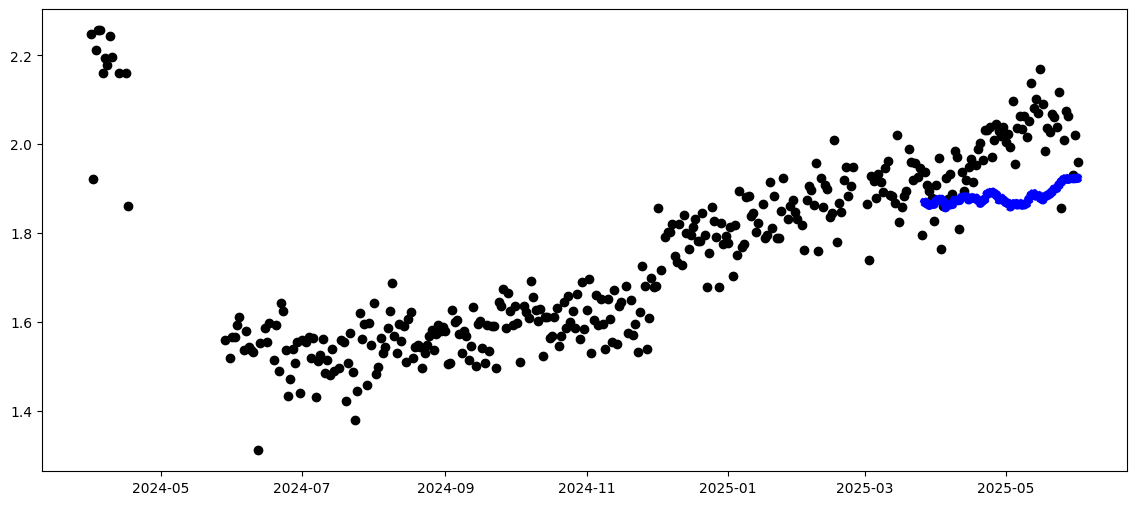

In [ ]:
# Даты
dates = df_daily['date']

# Даты для апроксимированных значений (по количеству окон тестовой выборки)
test_dates = dates[-len(y_test_rescaled):]

# Для корректного отображения берём только первый день прогноза в каждом окне
approx_values = y_pred_rescaled[:, 0]

# Даты для прогноза (14 дней вперёд)
last_date = dates.iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=31)

plt.figure(figsize=(14, 6))

# Фактические значения
plt.scatter(dates, df_daily['value'], label='Фактические значения', color='black')

# Апроксимированные значения (модель на тестовой выборке)
plt.scatter(test_dates, approx_values, label='Апроксимированные (модель)', color='blue', linestyle='--')

# Прогноз на 14 дней
plt.scatter(forecast_dates, forecast_rescaled, label='Прогноз (14 дней)', color='red', marker='o')

plt.xlabel('Дата')
plt.ylabel('Значение параметра')
plt.title('Фактические, апроксимированные и прогнозные значения')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
